# 导入必须的模块

In [1]:
# 导入模块
print("导入模块")
# !pip install pycocotools
# !pip uninstall torchvision
# !pip install -U torchvision==0.8.2
import os
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
!pip install seaborn
from util.plot_utils import plot_logs
from pathlib import Path
import torch
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.transforms as T
from predict import get_args_parser
import time
import datetime
print("模块导入成功")

导入模块
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
模块导入成功


#  参数配置

In [2]:
print("设置基本参数")
class config:
    lr = 1e-4 # 学习率
    lr_backbone = 1e-5 # backbone的学习率
    lr_drop = 50 # 学习率衰减
    batch_size = 1 # 批次大小
    weight_decay = 1e-4 # 权重衰减
    epochs = 1 # 训练回合数
    one_epoch_steps = 2 # 一个epoch中的迭代次数

    num_classes = 5 # 类别数

    dataset_file = "custom" # 使用自定义的数据库函数，不需要更改

    coco_path = r"MyDatasets" # 自定义数据集路径的路径

    # device = 'cuda' if torch.cuda.is_available() else "cpu" # device to use for training / testing
    device = "cpu"
    seed = 42 # 随机种子

    resume = "detr-r50_no-class-head.pth" # 'resume from checkpoint'

    num_workers = 2 # 读取数据的进程数
    output_dir= "outputs"

print("设置完成")

设置基本参数
设置完成


# 准备工作

In [3]:
# 获取配置参数
print("加载参数配置")
args = get_args_parser_predict(config()).parse_args([]) # 加载参数
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True) # 建立输出目录
# 初始化分布式模型参数配置
utils.init_distributed_mode(args)

# 打印参数配置信息
print(args)

# 设定cpu或者gpu环境
device = torch.device(args.device)

# 固定随机种子以便于复现
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print("加载完成")

加载参数配置
Not using distributed mode
Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='MyDatasets', dataset_file='custom', dec_layers=6, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=1, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=50, mask_loss_coef=1, masks=False, nheads=8, num_classes=5, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=3)
加载完成


# 评估阶段

In [5]:
print("加载评估参数配置")
!cp /home/admin/jupyter/resnet50-19c8e357.pth /home/admin/.cache/torch/hub/checkpoints/
# 读取分类标签
with open("mask_outdoor_classes.txt", "r")as f:
    finetuned_classes = f.read().split("\n")
# 类别数
num_classes = len(finetuned_classes)

# 对输入的图片进行resize和标准化
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 预先定义6种框的颜色，保证每种类别有一个独立颜色的框
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# 定义读取图片的路径
img_name = ""

# 读取模型网络
model, _, _ = build_model(args)

# 读取自己训练好的模型权重
checkpoint = torch.load('outputs/detr_outdoor.pth',
                            map_location='cpu')

model.load_state_dict(checkpoint['model'],
                          strict=False)

model.eval()
print("加载完成")

加载评估参数配置
加载完成


In [6]:
# 将模型输出的box的表示由xmid,ymid,width,height 转化为 xmin,ymin,xmax,ymax方便画图
print("定义各种绘制函数")
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# 根据图片尺寸对框进行等比例变化以适应
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    # 转换图片框的数据格式
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# 根据阈值对输出的框进行过滤
def filter_bboxes_from_outputs(outputs,
                               threshold, im):
    # 只输出超过阈值的框
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # 对框的数据比例进行转换，使其匹配图片尺寸
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled
# 将框，分类，score等信息绘制到图片上并显示和保存
def plot_finetuned_results(pil_img, prob=None, boxes=None):
#     global img_name
    # 定义显示框
    plt.figure(figsize=(16, 10))
    # 显示图片
    plt.imshow(pil_img)
    ax = plt.gca()
    # 定义颜色
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        # 绘制检测框和对应的类别到图片上
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            # 绘制框
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            cl = p.argmax()
            # 绘制文字
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
            box = boxes.tolist()
            box = [int(val) for val in box[0]]
            print(f"预测类别：{finetuned_classes[cl]}，置信度：{p[cl]:0.2f}，位置：{box}")
    plt.axis('off')
    # 保存图片
#     plt.savefig(img_name.split("/")[-1].replace(".jpg","")+"_result.jpg")
# 用模型对图片进行预测，并绘制框，类别等信息
def run_worflow(my_image, my_model):
    # 对图片进行处理以便与输入到模型
    img = transform(my_image).unsqueeze(0)
    start_time = time.time()
    # 使用模型进行预测
    outputs = my_model(img)
    for threshold in [0.8]:
        # 设定阈值对框进行过滤
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                   threshold=threshold,im=my_image)
        # 将符合条件的框绘制到图片上
        plot_finetuned_results(my_image,probas_to_keep,bboxes_scaled)
    # 计算耗费的时间
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("预测耗时：",total_time_str)
# 读入图片进行预测
def img_predict(img_pth):
    # 读取图片进行预测
    im = Image.open(img_pth)
    run_worflow(im, model)
print("定义完成")

定义各种绘制函数
定义完成


开始预测
预测类别：roadblock，置信度：1.00，位置：[288, 147, 637, 818]
预测耗时： 0:02:16
预测完成


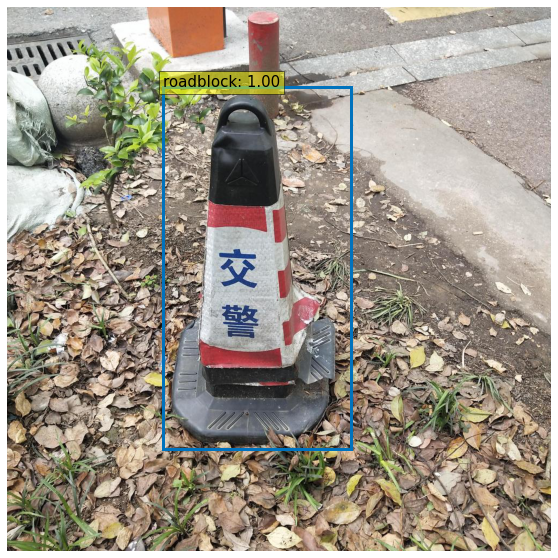

In [7]:
# 部分图片可视化测试.
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/LZ122.jpg')
print("预测完成")

开始预测
预测类别：stairs，置信度：0.95，位置：[243, 780, 622, 1174]
预测耗时： 0:02:19
预测完成


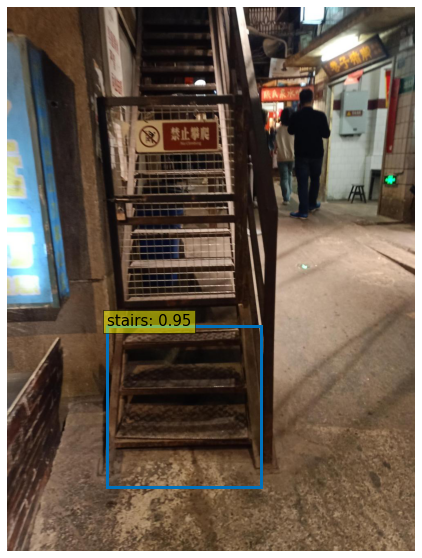

In [8]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/LT49.jpg')
print("预测完成")

开始预测
预测类别：traffic light，置信度：0.99，位置：[507, 219, 963, 1002]
预测耗时： 0:02:14
预测完成


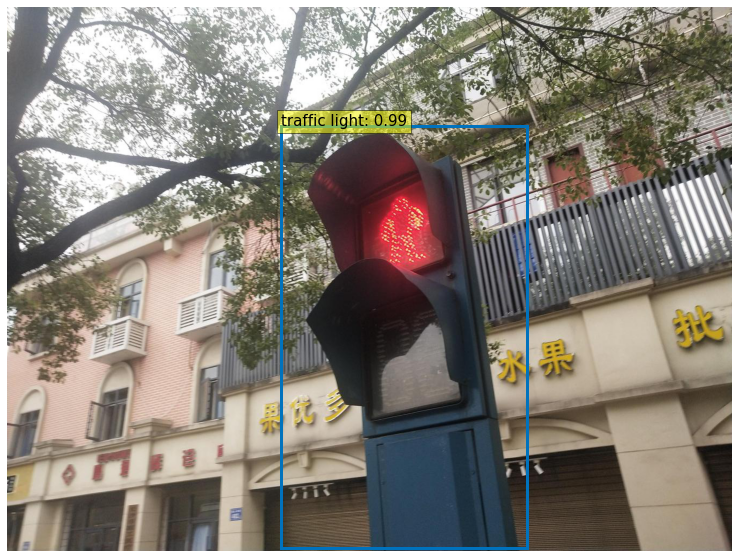

In [9]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/hld011.jpg')
print("预测完成")

In [ ]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/75.jpg')
print("预测完成")

开始预测
